<a href="https://colab.research.google.com/github/Is7ac/ML/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [39]:
# Load the Iris dataset
iris_data = datasets.load_iris()

# Extract features and target variable
X = iris_data.data  # Features
y = iris_data.target  # Target variable

# Print the shape of features and target variable
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of features (X): (150, 4)
Shape of target variable (y): (150,)


four parameters when using all the features.






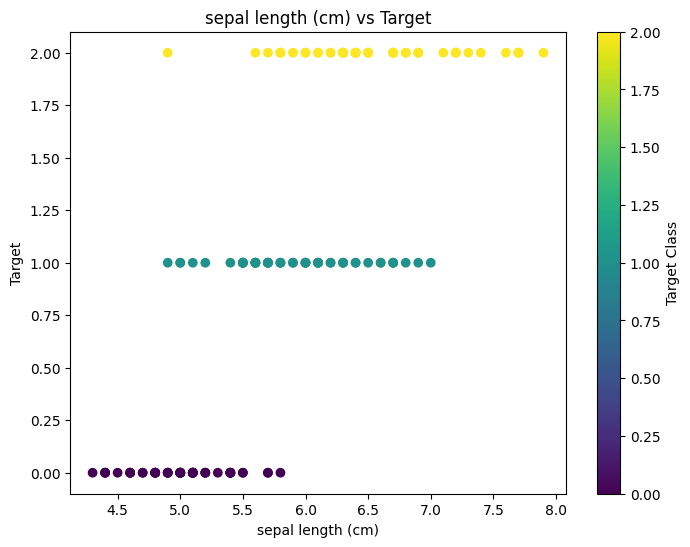

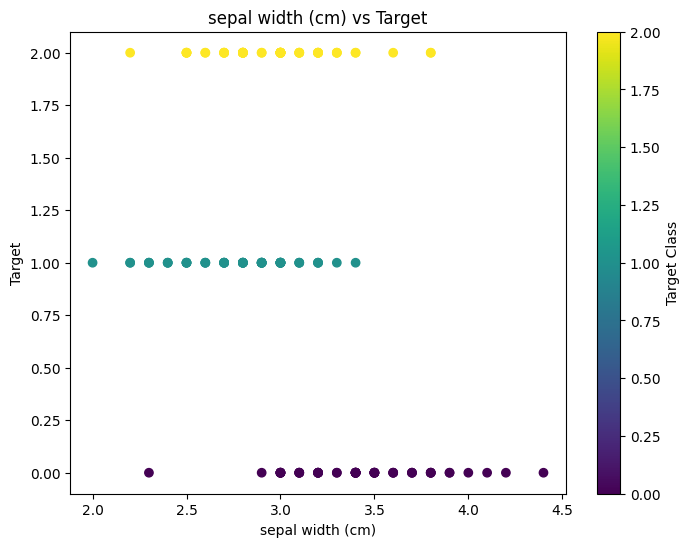

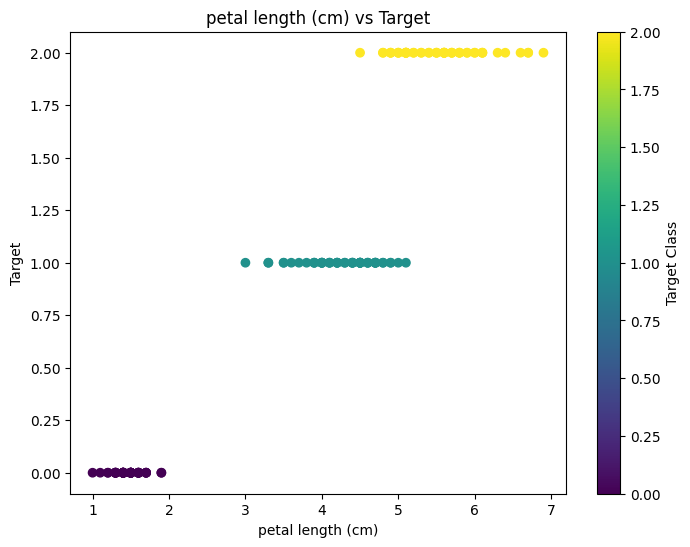

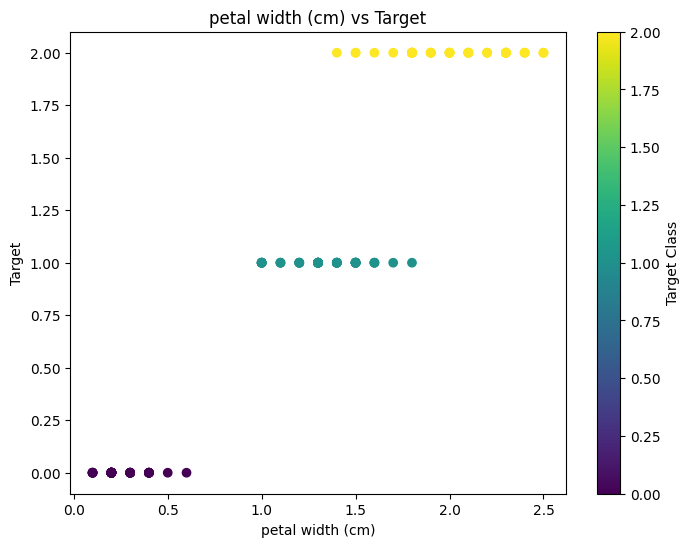

In [40]:
# Get feature names
feature_names = iris_data.feature_names

# Plot each feature against the target
for i in range(len(feature_names)):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, i], y, c=y, cmap='viridis')
    plt.xlabel(feature_names[i])
    plt.ylabel('Target')
    plt.title(f"{feature_names[i]} vs Target")
    plt.colorbar(label='Target Class')
    plt.show()


In [41]:
# Compute the mean of each feature for each class
class_means = np.array([X[y == i].mean(axis=0) for i in range(len(np.unique(y)))])

# Compute the overall mean of each feature
overall_mean = X.mean(axis=0)

# Compute the within-class scatter matrix (SW)
within_class_scatter = sum([np.dot((X[y == i] - class_means[i]).T, (X[y == i] - class_means[i])) for i in range(len(np.unique(y)))])

# Compute the Fisher score for each feature
epsilon = 1e-9  # small constant to avoid division by zero
fisher_scores = np.array([((class_means[:, i] - overall_mean[i])**2).sum() / (within_class_scatter[i, i] + epsilon) for i in range(X.shape[1])])

# Choose the feature with the highest separability
best_feature_index = np.argmax(fisher_scores)
best_feature_name = iris_data.feature_names[best_feature_index]
best_feature_score = fisher_scores[best_feature_index]

print(f"The feature '{best_feature_name}' produces the highest separability with a Fisher score of {best_feature_score:.4f}.")

The feature 'petal length (cm)' produces the highest separability with a Fisher score of 0.3211.


In [42]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def log_loss(self, y, y_pred):
        # Avoiding division by zero and numerical instability
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

        # Calculating log loss
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def fit(self, X, y):
        # Add bias term
        X = np.column_stack((np.ones(len(X)), X))
        num_samples, num_features = X.shape
        print(num_samples)

        # Initialize weights
        self.weights = np.zeros(num_features)

        # Gradient descent
        for _ in range(self.num_iterations):
            # Compute predictions
            y_pred = self.sigmoid(np.dot(X, self.weights))

            # Compute gradients
            gradient = np.dot(X.T, (y_pred - y)) / num_samples

            # Update weights
            self.weights -= self.learning_rate * gradient
            if (_==0):
              print(self.weights)
              print(np.sum(X.T, axis=1))

    def predict(self, X):
        # Add bias term
        X = np.column_stack((np.ones(len(X)), X))

        # Predict probability
        y_pred = self.sigmoid(np.dot(X, self.weights))

        # Convert probabilities to binary predictions
        return (y_pred > 0.5).astype(int)

In [43]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
lr_model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
lr_model.fit(X_train, y_train)

# Print weights
print("Weights:", lr_model.weights)

# Calculate log loss on the training set
y_pred_train = lr_model.predict(X_train)
train_log_loss = lr_model.log_loss(y_train, lr_model.sigmoid(np.dot(np.column_stack((np.ones(len(X_train)), X_train)), lr_model.weights)))
print("Training Log Loss:", train_log_loss)

# Calculate log loss on the test set
y_pred_test = lr_model.predict(X_test)
test_log_loss = lr_model.log_loss(y_test, lr_model.sigmoid(np.dot(np.column_stack((np.ones(len(X_test)), X_test)), lr_model.weights)))
print("Test Log Loss:", test_log_loss)

120
[0.00491667 0.03364583 0.01344167 0.03174167 0.0116    ]
[120.  697.1 367.4 447.2 142. ]
Weights: [-0.04082381  4.83310278 -1.73283752 13.23336286  5.71984671]
Training Log Loss: 0.2148552940974587
Test Log Loss: -1.1513191997446954


In [44]:
class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.num_classes = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def log_loss(self, y, y_pred):
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))

    def fit(self, X, y):
        # Add bias term
        X = np.column_stack((np.ones(len(X)), X))
        num_samples, num_features = X.shape

        # Determine number of classes
        self.num_classes = len(np.unique(y))

        # Initialize weights
        self.weights = np.zeros((num_features, self.num_classes))

        # One-hot encode labels
        y_one_hot = np.eye(self.num_classes)[y]

        # Gradient descent
        for _ in range(self.num_iterations):
            # Compute predictions
            y_pred = self.softmax(np.dot(X, self.weights))

            # Compute gradients
            gradient = np.dot(X.T, (y_pred - y_one_hot)) / num_samples

            # Update weights
            self.weights -= self.learning_rate * gradient

    def predict(self, X):
        # Add bias term
        X = np.column_stack((np.ones(len(X)), X))

        # Predict probability
        y_pred = self.softmax(np.dot(X, self.weights))

        # Convert probabilities to class labels
        return np.argmax(y_pred, axis=1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train multiclass logistic regression model
lr_model = MulticlassLogisticRegression(learning_rate=0.01, num_iterations=1000)
lr_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = lr_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0
